In [27]:
import numpy as np
import pandas as pd
from statsbombpy import sb
import networkx as nx

In [28]:
#Import competition data to find season we are interested in: La Liga - 2020/2021
competition_df = sb.competitions()
season = competition_df[ (competition_df.competition_name == 'La Liga') & (competition_df.season_name == '2020/2021') ]

C:\Users\Lawrence\AppData\Local\Programs\Python\Python39\lib\site-packages\statsbombpy\api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


In [29]:
#Find the matches where Barcelona played. Could be as home team or away team
season_matches = sb.matches(competition_id = season.competition_id.iloc[0],season_id = season.season_id.iloc[0])
barcelona_matches = season_matches[ (season_matches.home_team == 'Barcelona') | ( season_matches.away_team == 'Barcelona') ]
#Note that matches are not in date order

In [30]:
#Loop through Barcelona's matches and create DataFrame for all Barcelona's passes in the season
season_barcelona_passes = pd.DataFrame()
#Currently doing just 10 matches as it takes a long time
for match_id_iter in barcelona_matches.match_id[0:10]:
    match_iter = sb.events(match_id=match_id_iter)
    match_iter = match_iter[(match_iter.type == 'Pass') & (match_iter.team == 'Barcelona')]
    season_barcelona_passes = pd.concat([season_barcelona_passes, match_iter[['player','pass_recipient','location','pass_end_location','pass_length']]], ignore_index=True)
season_barcelona_passes

,player,pass_recipient,location,pass_end_location,pass_length
0,Lionel Andrés Messi Cuccittini,Ousmane Dembélé,"[61.0, 40.1]","[59.2, 38.0]",2.765863
1,Ousmane Dembélé,Sergio Busquets i Burgos,"[58.3, 38.6]","[48.6, 47.8]",13.368994
2,Sergio Busquets i Burgos,Sergino Dest,"[48.0, 49.8]","[54.6, 74.3]",25.373411
3,Sergino Dest,Óscar Mingueza García,"[55.5, 74.3]","[41.9, 66.8]",15.530937
4,Óscar Mingueza García,Frenkie de Jong,"[41.9, 65.7]","[35.9, 47.0]",19.638992
...,...,...,...,...,...
7817,Francisco António Machado Mota de Castro Trincão,NaN,"[116.7, 57.0]","[116.9, 55.5]",1.513275
7818,Francisco António Machado Mota de Castro Trincão,Sergi Roberto Carnicer,"[120.0, 80.0]","[112.6, 72.4]",10.607545
7819,Sergi Roberto Carnicer,Francisco António Machado Mota de Castro Trincão,"[113.8, 68.9]","[93.9, 67.3]",19.964218
7820,Francisco António Machado Mota de Castro Trincão,Sergino Dest,"[93.7, 66.1]","[82.7, 48.1]",21.095022


In [31]:
#Find the unique pass combinations, ie all the different pairings of passer and receiver
unique_pass_combinations = season_barcelona_passes.groupby(['player','pass_recipient']).size().reset_index().rename(columns={0:'count'})
unique_pass_combinations['weight'] = np.nan

#Find the total number of passes between players
for i,row in unique_pass_combinations.iterrows():
    unique_pass_combinations.weight[i] = season_barcelona_passes[(season_barcelona_passes.player == row.player) & (season_barcelona_passes.pass_recipient == row.pass_recipient)].pass_length.sum()

#Normalise the weight
unique_pass_combinations['weight'] = unique_pass_combinations['weight'] / unique_pass_combinations['weight'].max()

unique_pass_combinations

C:\Users\Lawrence\AppData\Local\Temp/ipykernel_16828/787750850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_pass_combinations.weight[i] = season_barcelona_passes[(season_barcelona_passes.player == row.player) & (season_barcelona_passes.pass_recipient == row.pass_recipient)].pass_length.sum()


,player,pass_recipient,count,weight
0,Anssumane Fati,Antoine Griezmann,5,0.022601
1,Anssumane Fati,Francisco António Machado Mota de Castro Trincão,1,0.005185
2,Anssumane Fati,Frenkie de Jong,6,0.023236
3,Anssumane Fati,Gerard Piqué Bernabéu,2,0.016681
4,Anssumane Fati,Jordi Alba Ramos,8,0.023651
...,...,...,...,...
413,Óscar Mingueza García,Ronald Federico Araújo da Silva,12,0.081673
414,Óscar Mingueza García,Samuel Yves Umtiti,18,0.168078
415,Óscar Mingueza García,Sergi Roberto Carnicer,21,0.130035
416,Óscar Mingueza García,Sergino Dest,50,0.292450


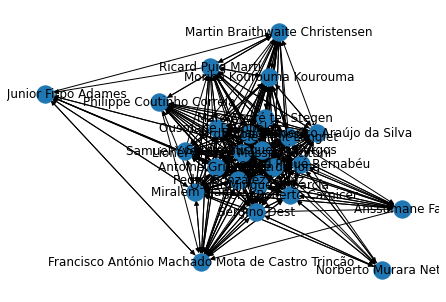

In [32]:
#Make and plot the graph with networkx
G = nx.from_pandas_edgelist(unique_pass_combinations,'player','pass_recipient',edge_attr='weight',create_using=nx.DiGraph())
nx.draw(G,with_labels=True)

In [33]:
#Calculate some centrality measures on the players
player_centrality = pd.DataFrame(G.nodes()).rename(columns={0:'player'})
player_centrality['betweeness'] = pd.Series(nx.betweenness_centrality(G)).values
player_centrality['closeness'] = pd.Series(nx.closeness_centrality(G)).values
player_centrality['pagerank'] = pd.Series(nx.pagerank(G)).values
player_centrality

,player,betweeness,closeness,pagerank
0,Anssumane Fati,0.000000,0.638889,0.012564
1,Antoine Griezmann,0.022916,0.958333,0.062291
2,Francisco António Machado Mota de Castro Trincão,0.012741,0.884615,0.020973
3,Frenkie de Jong,0.017597,0.958333,0.071094
4,Gerard Piqué Bernabéu,0.016013,0.884615,0.060628
5,Jordi Alba Ramos,0.017785,0.884615,0.102637
6,Lionel Andrés Messi Cuccittini,0.011734,0.920000,0.087590
7,Miralem Pjanić,0.032880,0.851852,0.026640
8,Pedro González López,0.009689,0.884615,0.051503
9,Sergi Roberto Carnicer,0.022304,0.920000,0.048581


In [34]:
#Average each players' betweeness, closeness and pagerank centrality to get score
player_centrality['mean'] = np.nan
for i,player in player_centrality.iterrows():
    mean = (player.pagerank + player.closeness + 0.3*player.betweeness)/3
    player_centrality.loc[i,'mean'] = mean

player_centrality = player_centrality.sort_values(by='mean',ascending=False)
player_centrality.head(5)

,player,betweeness,closeness,pagerank,mean
10,Sergio Busquets i Burgos,0.024350,0.958333,0.071578,0.345739
3,Frenkie de Jong,0.017597,0.958333,0.071094,0.344902
1,Antoine Griezmann,0.022916,0.958333,0.062291,0.342500
6,Lionel Andrés Messi Cuccittini,0.011734,0.920000,0.087590,0.337037
5,Jordi Alba Ramos,0.017785,0.884615,0.102637,0.330863


In [35]:
#For better, interactive plotting of the graph

#Sourced from:
#https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html

from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

In [36]:
#Calculating the weighted degree of each node to act as ranking for appearance on graph
weighted_degrees = dict(nx.degree(G, weight='Weight'))
nx.set_node_attributes(G, name='weighted_degree', values=weighted_degrees)

In [37]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'weighted_degree'
color_by_this_attribute = 'weighted_degree'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Barcelona Pass Graph'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Player", "@index"),
        ("Weighted Degree", "@weighted_degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")